Reference: https://jump.dev/JuMP.jl/stable/tutorials/algorithms/tsp_lazy_constraints/

In [72]:
versioninfo()

Julia Version 1.9.3
Commit bed2cd540a1 (2023-08-24 14:43 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 24 × AMD Ryzen 9 5900X 12-Core Processor
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, znver3)
  Threads: 2 on 24 virtual cores
Environment:
  LD_LIBRARY_PATH = :/opt/gurobi1003/linux64/lib:/opt/gurobi1003/linux64/lib:/usr/local/cuda-12.1/lib64:/opt/gurobi1003/linux64/lib


In [73]:
using JuMP # JuMP v1.16.0
using Gurobi # Gurobi v1.1.0
using Random 
using Plots # Plots v1.39.0
using Concorde # Concorde v0.1.3

In [74]:
using Pkg
Pkg.status()

Status `~/.julia/environments/v1.9/Project.toml`
  [4cecd8e0] BPPLib v1.0.0 `https://github.com/rafaelmartinelli/BPPLib.jl#main`
⌃ [a076750e] CPLEX v1.0.2
⌃ [336ed68f] CSV v0.10.11
  [6232a4dd] CVRPLIB v0.3.0
  [49b9cb24] CVRPSEP v0.1.0 `https://github.com/chkwon/CVRPSEP.jl.git#master`
  [a81c6b42] Compose v0.9.5
  [df6a336b] Concorde v0.1.3
⌅ [a93c6f00] DataFrames v0.20.2
⌃ [864edb3b] DataStructures v0.18.15
⌃ [90d7349d] Erdos v0.7.0
  [60bf3e95] GLPK v1.1.3
  [a2cc645c] GraphPlot v0.5.2
  [86223c79] Graphs v1.9.0
⌃ [2e9cd046] Gurobi v1.1.0
⌃ [87dc4568] HiGHS v1.7.5
  [7073ff75] IJulia v1.24.2
⌃ [4076af6c] JuMP v1.16.0
  [093fc24a] LightGraphs v1.3.5
  [fbb45041] Pickle v0.3.3
⌅ [91a5bcdd] Plots v1.39.0
  [438e738f] PyCall v1.96.4
  [d330b81b] PyPlot v2.11.2
  [47aef6b3] SimpleWeightedGraphs v1.4.0
⌅ [2913bbd2] StatsBase v0.33.21
  [b1c258e7] TSPLIB v0.1.2
  [735ffce8] TrafficAssignment v0.6.3
  [ad70616a] Wandb v0.5.1
  [708e8d2e] CVRPSEP_jll v0.1.0+0
Info Packages marked with ⌃ and 

In [75]:
function find_tour(x::Matrix{Float64}, n)
    # Create a list of selected edges
    selected = selected_edges(x, n)

    # Create an adjacency list representation of the graph
    adj_list = Dict{Int, Vector{Int}}()
    for (i, j) in selected
        push!(get!(adj_list, i, []), j)
        push!(get!(adj_list, j, []), i)
    end

    # Perform depth-first search (DFS) to find the tour
    visited = Set{Int}()
    tour = [1]
    dfs!(adj_list, visited, tour, 1)

    return tour
end

function dfs!(adj_list, visited, tour, node)
    push!(visited, node)
    for neighbor in adj_list[node]
        if !(neighbor in visited)
            push!(tour, neighbor)
            dfs!(adj_list, visited, tour, neighbor)
        end
    end
end

dfs! (generic function with 1 method)

In [76]:
function plot_tour(X, Y, x)
    plot = Plots.plot()
    for (i, j) in selected_edges(x, size(x, 1))
        Plots.plot!([X[i], X[j]], [Y[i], Y[j]]; legend = false)
    end
    xlims!(0, 100) 
    ylims!(0, 100)  
    xlabel!("X")
    ylabel!("Y")
    title!("TSP Plot")
    return plot
end

function selected_edges(x::Matrix{Float64}, n)
    return Tuple{Int,Int}[(i, j) for i in 1:n, j in 1:n if x[i, j] > 0.5]
end

subtour(x::Matrix{Float64}) = subtour(selected_edges(x, size(x, 1)), size(x, 1)) # solution
subtour(x::AbstractMatrix{VariableRef}) = subtour(value.(x)) # cycle

subtour (generic function with 3 methods)

# #1 Generate Instance

In [77]:
function generate_distance_matrix(n; random_seed=1234)
    rng = Random.MersenneTwister(random_seed)
    X = 100 * rand(rng, n) # x 좌표
    Y = 100 * rand(rng, n) # y 좌표
    d = [sqrt((X[i] - X[j])^2 + (Y[i] - Y[j])^2) for i in 1:n, j in 1:n] #distance
    return X, Y, d
end

generate_distance_matrix (generic function with 1 method)

In [78]:
n = 50
X, Y, d = generate_distance_matrix(n)

([59.08446386657103, 76.67970365022592, 56.623741650618584, 46.008534246251706, 79.40257103317943, 85.41465903790501, 20.05860349338411, 29.861427834341182, 24.683718661000896, 57.96722333690416  …  4.62887410313455, 69.83555060532487, 36.51093677271471, 30.24777928234499, 37.25754415996787, 15.050782744925794, 14.732938279328955, 28.34013103457036, 40.4952833648838, 49.9530744114878], [65.88147837334961, 51.56272179795256, 26.071522632820777, 59.5520484050929, 29.24615242315285, 28.85798506061561, 61.81597973815087, 66.42598175011504, 75.35081177709988, 3.688418241886171  …  63.342737114607075, 33.78650847422675, 11.29874379422362, 78.2990311670619, 83.80421929441088, 8.785980672452753, 38.65675692738708, 33.05786837164975, 74.80405976865343, 26.559536159694797], [0.0 22.685221024045322 … 20.619653015512423 40.36827235384756; 22.685221024045322 0.0 … 43.00548874335252 36.59879782897453; … ; 20.619653015512423 43.00548874335252 … 0.0 49.1628301640232; 40.36827235384756 36.5987978289745

# #2 Full model

In [79]:
function tsp_model(d, n)
    model = Model(Gurobi.Optimizer)
    @variable(model, x[1:n, 1:n], Bin)
    @variable(model, t[1:n])

    @objective(model, Min, sum(d .* x))
    @constraint(model, [i in 1:n], sum(x[i, :]) == 1)
    @constraint(model, [j in 1:n], sum(x[:, j]) == 1)
    @constraint(model, [i in 2:n, j in 2:n], t[j] >= t[i] + n * x[i, j] - (n - 1))

    return model
end

tsp_model (generic function with 1 method)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-21
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 2501 rows, 2550 columns and 12105 nonzeros
Model fingerprint: 0x8299afc3
Variable types: 50 continuous, 2500 integer (2500 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [3e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 49 rows and 51 columns
Presolve time: 0.02s
Presolved: 2452 rows, 2499 columns, 11862 nonzeros
Variable types: 48 continuous, 2451 integer (2451 binary)

Root relaxation: objective 4.395169e+02, 215 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbe

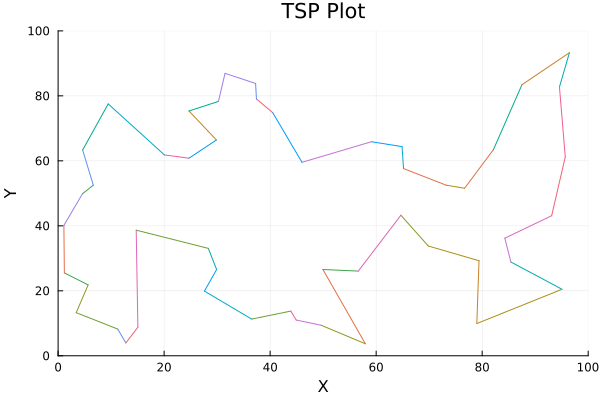

In [80]:
full_model = tsp_model(d, n)
optimize!(full_model) 
opt = objective_value(full_model)
sol = value.(full_model[:x])
time_full = solve_time(full_model)

println("--------------------")
println("Optimal tour: ", find_tour(sol, n))
println("Optimal tour length: ", opt)
println("time iterated: ", time_full)
plot_tour(X, Y, sol)


# #3 Lazy model

In [83]:
function build_tsp_model(d, n)
    model = Model(Gurobi.Optimizer)
    @variable(model, x[1:n, 1:n], Bin, Symmetric)
    @objective(model, Min, sum(d .* x) / 2)
    @constraint(model, [i in 1:n], sum(x[i, :]) == 2)
    @constraint(model, [i in 1:n], x[i, i] == 0)
    return model
end

build_tsp_model (generic function with 1 method)

In [84]:
function subtour(edges::Vector{Tuple{Int,Int}}, n) # subtour 찾기
    shortest_subtour, unvisited = collect(1:n), Set(collect(1:n))
    while !isempty(unvisited)
        this_cycle, neighbors = Int[], unvisited
        while !isempty(neighbors)
            current = pop!(neighbors)
            push!(this_cycle, current)
            if length(this_cycle) > 1
                pop!(unvisited, current)
            end
            neighbors = [j for (i, j) in edges if i == current && j in unvisited]
        end
        if length(this_cycle) < length(shortest_subtour)
            shortest_subtour = this_cycle
        end
    end
    return shortest_subtour
end

subtour (generic function with 3 methods)

In [85]:
function subtour_elimination_callback(cb_data)
    status = callback_node_status(cb_data, lazy_model)
    if status != MOI.CALLBACK_NODE_STATUS_INTEGER
        return  # Only run at integer solutions
    end
    cycle = subtour(callback_value.(cb_data, lazy_model[:x]))
    if !(1 < length(cycle) < n)
        return  # Only add a constraint if there is a cycle
    end
    println("Found cycle of length $(length(cycle))")
    global all_cycles
    push!(all_cycles, cycle)
    #display(plot_cycle(X, Y, cycle))
    
    S = [(i, j) for (i, j) in Iterators.product(cycle, cycle) if i < j]
    con = @build_constraint(
        sum(lazy_model[:x][i, j] for (i, j) in S) <= length(cycle) - 1,
    )
    MOI.submit(lazy_model, MOI.LazyConstraint(cb_data), con)
    return
end

subtour_elimination_callback (generic function with 1 method)

In [86]:
function plot_cycle(X, Y, cycle)
    plot = Plots.plot()
    for k in 1:length(cycle)
        if k == length(cycle)
            i, j = cycle[length(cycle)], cycle[1]
        else
            i, j = cycle[k], cycle[k+1]
        end
        Plots.plot!([X[i], X[j]], [Y[i], Y[j]]; legend = false)
    end
    xlims!(0, 100) 
    ylims!(0, 100)  
    xlabel!("X")
    ylabel!("Y")
    return plot
end

plot_cycle (generic function with 1 method)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-21
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 100 rows, 1275 columns and 2550 nonzeros
Model fingerprint: 0x55d97ab8
Variable types: 0 continuous, 1275 integer (1275 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+00]
Found cycle of length 4
Presolve removed 50 rows and 50 columns
Presolve time: 0.00s
Presolved: 50 rows, 1225 columns, 2450 nonzeros
Variable types: 0 continuous, 1225 integer (1225 binary)
Found cycle of length 3
Found cycle of length 4

Root relaxation: objective 5.106649e+02, 76 iterations, 0.00 seconds (0.00 work units)

    Nodes  

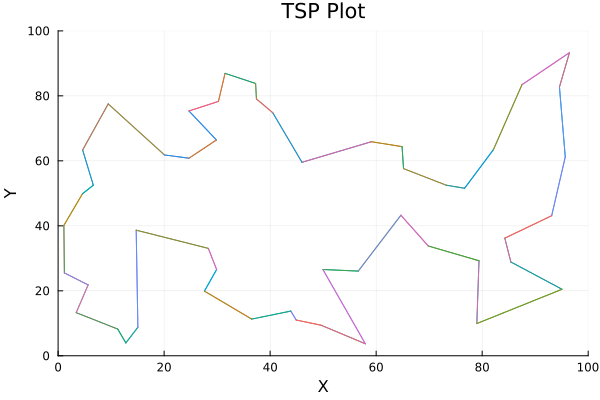

In [87]:
all_cycles = []
lazy_model = build_tsp_model(d, n)
set_attribute(
    lazy_model,
    MOI.LazyConstraintCallback(),
    subtour_elimination_callback,
)
optimize!(lazy_model)
# @assert is_solved_and_feasible(lazy_model)
opt = objective_value(lazy_model)
sol = value.(lazy_model[:x])
time_lazy = solve_time(lazy_model)

println("--------------------")
println("Optimal tour: ", find_tour(sol, n))
println("Optimal tour length: ", opt)
println("time iterated: ", time_lazy)
push!(all_cycles, find_tour(sol, n))
plot_tour(X, Y, sol)

[ Info: Saved animation to /home/yoonju/julia_project/study/TSPsolver/tsp_cycles.gif


Plots.AnimatedGif("/home/yoonju/julia_project/study/TSPsolver/tsp_cycles.gif")
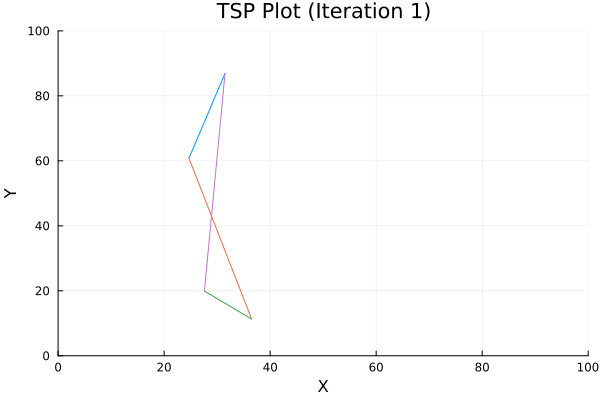

In [88]:
# Plot each cycle and save frames
anim = @animate for i in 1:length(all_cycles)
    plot_cycle(X, Y, all_cycles[i])
    title!("TSP Plot (Iteration $i)")
end

# Save the animation as a GIF
gif(anim, "tsp_cycles.gif", fps = 2)

# #4 Concorde

Optimal tour: [1, 11, 18, 37, 2, 25, 40, 22, 23, 14, 31, 20, 6, 21, 24, 5, 42, 15, 3, 50, 10, 36, 39, 32, 43, 17, 38, 48, 47, 46, 29, 16, 26, 19, 34, 12, 35, 13, 41, 27, 7, 33, 8, 9, 44, 28, 45, 30, 49, 4]
Optimal tour length: 556
time iterated: 0.148061484


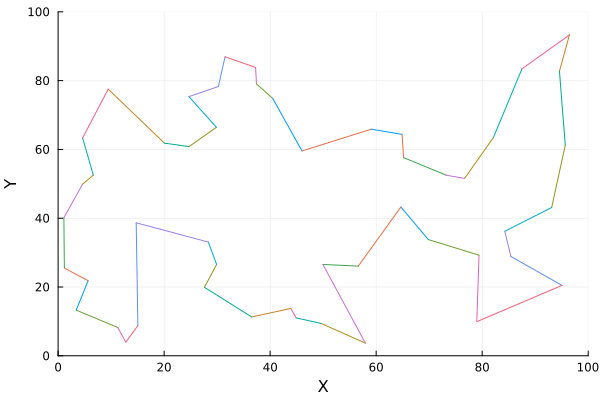

In [89]:
using Concorde
opt_tour, opt_len = solve_tsp(X, Y; dist="EUC_2D")
elapsed_time = @elapsed solve_tsp(X, Y; dist="EUC_2D")
println("Optimal tour: ", opt_tour)
println("Optimal tour length: ", opt_len)
println("time iterated: ", elapsed_time)
display(plot_cycle(X, Y, opt_tour))